# Sistema de detección de enlaces spam

Queremos implementar un sistema que sea capaz de detectar automáticamente si una página web contiene spam o no basándonos en su URL.

## 0. Importar librerías

In [78]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from pickle import dump


## 1. Cargar del conjunto de datos

In [26]:
total_data = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=932&path=url_spam.csv")
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


## 2. Preprocesamiento de datos

**2.1. Transformación de categórico a numérrico**

In [27]:
total_data["is_spam"] = total_data["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


**2.2. Eliminación de valores repetidos**

In [28]:
print(total_data.shape)
print(f"Spam: {len(total_data.loc[total_data.is_spam == 1])}")
print(f"No spam: {len(total_data.loc[total_data.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


In [29]:
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace = False, drop = True)
total_data.shape

(2369, 2)

**2.3. Procesamiento del texto**

In [47]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_url(url):

    tokens = re.split(r'\W+', url)
    tokens = [t for t in tokens if t and t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens


total_data["url"] = total_data["url"].apply(lambda x: preprocess_url(x) if isinstance(x, str) else x)
total_data.head()


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


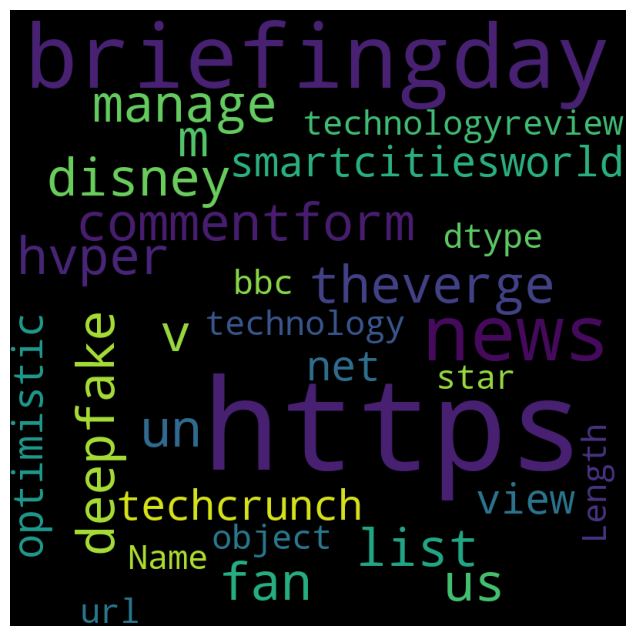

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [62]:
tokens_list = total_data["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 691))

## 3. Construye un SVM


**3.1. División en conjuntos de entrenamiento y prueba**

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


**3.2. Inicialización y entrenamiento del modelo**

In [67]:
model = SVC(kernel = "rbf", C = 1.0, gamma = 0.5)
model.fit(X_train, y_train)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,0.5
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [74]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.959915611814346

## 4. Optimización de hiperparámetros

In [69]:
hiperparametros = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'degree': [2, 3, 4]     
}

In [75]:
grid = GridSearchCV(SVC(), hiperparametros, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor score:", grid.best_score_)

Mejores parámetros: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor score: 0.9292881167793402


In [76]:
model = SVC(kernel = "rbf", C = 1.0, degree = 2, gamma= "scale")
model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,2
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [77]:
accuracy_score(y_test, y_pred)

0.959915611814346

## 5. Guardar el modelo entrenado

In [79]:
dump(model, open("../models/svm_classifier_linear_42.sav", "wb"))